In [1]:
import os
os.chdir('../')

In [21]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    model_path: Path
    test_data_path: Path
    confusion_matrix: Path
    confusion_matrix_plot: Path
    target_column:str

In [22]:
from mlProject.constants import *
from mlProject.utils.common import read_yaml, create_directories

In [27]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
            config = self.config.model_evaluation
            params = self.params.ElasticNet
            schema =  self.schema.TARGET_COLUMN

            create_directories([config.root_dir])

            model_evaluation_config = ModelEvaluationConfig(
                root_dir=config.root_dir,
                model_path=config.model_path,
                test_data_path = config.test_data_path,
                confusion_matrix = config.confusion_matrix,
                confusion_matrix_plot = config.confusion_matrix_plot,
                target_column = schema.name
                
            )

            return model_evaluation_config
    

In [24]:
import pandas as pd
import os
from mlProject import logger
import numpy as np
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [32]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
    

    def evaluate(self):

        test_data = pd.read_csv(self.config.test_data_path)
        model = joblib.load(self.config.model_path)

        test_x = test_data.drop([self.config.target_column], axis=1)
        test_y = test_data[[self.config.target_column]]

        predicted_y = np.around(model.predict(test_x)).astype(int)

        cm = pd.DataFrame()
        cm['y_true'] = test_y
        cm['y_predicted'] = predicted_y

        cm.to_csv(self.config.confusion_matrix)

        matrix = confusion_matrix(y_pred=predicted_y, y_true=test_y)

        fig = ConfusionMatrixDisplay(matrix)
        fig.plot()
        plt.savefig(self.config.confusion_matrix_plot)

[2024-02-14 14:13:42,210: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-02-14 14:13:42,210: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-14 14:13:42,210: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-02-14 14:13:42,210: INFO: common: created directory at: artifacts]
[2024-02-14 14:13:42,210: INFO: common: created directory at: artifacts/model_evaluation]


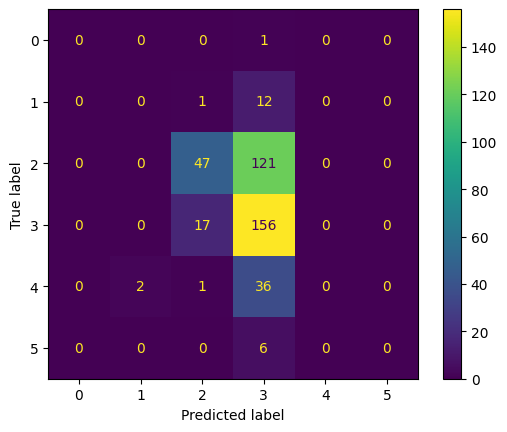

In [33]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)
    model_evaluation.evaluate()
except Exception as e:
    raise e